Tutorial from: https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/ 

Aim: Use ML to predict the grade of diabetic retinopathy from a fundus image. Therefore a multi-class image classification problem. Solved by using a pre-trained model InceptionResNetV2, and customizing it.

InceptionResNetV2: is a convolutional neural network that is 164 layers deep, trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories such as flowers, animals, etc. The input size of the images is 299-by-299.

Necessities for transfer learning: Low-level features from model A (task A) should be helpful for learning model B (task B).

In [2]:
# Import

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


2023-09-15 16:36:59.453102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 16:37:06.797654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Set up

data_path = './data/UoA-DR/' 
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, "test") 
label_path = os.path.join(data_path, 'UoA-DR-labels.csv')

labels = pd.read_csv(label_path)

x_name = "image number"
y_name = "class"

possible_labels = sorted(labels[y_name].unique())
print(possible_labels)

labels.head()

# print("Train Path:", train_path)
# print("Validation Path:", test_path)



['healthy', 'npdr', 'pdr']


,image number,class,healthy,npdr,pdr
0,1,npdr,0,1,0
1,2,npdr,0,1,0
2,3,npdr,0,1,0
3,4,npdr,0,1,0
4,5,npdr,0,1,0


In [4]:
# Custom function to convert image number to file path
extension = ".jpg"
def to_file_path(id):
    return os.path.join(labels[labels[x_name] == id][y_name].values[0], id + extension)

# Custom functions to convert image number with JPG extension
def to_jpg(id):
    return str(id) + ".jpg"

# Apply the to_file_path function if the folder is sorted by class, otherwise apply the to_jpg function
if len(os.listdir(os.path.join(train_path))) > 1 and len(os.listdir(os.path.join(test_path))) > 1:
    conversion = to_file_path
elif len(os.listdir(os.path.join(train_path))) == 0 and len(os.listdir(os.path.join(test_path))) == 0:
    conversion = to_jpg
else:
    print("Error with training and testing file sizes")
    
labels[x_name] = labels[x_name].astype(str)
labels[x_name] = labels[x_name].apply(conversion)

labels.head()


,image number,class,healthy,npdr,pdr
0,npdr/1.jpg,npdr,0,1,0
1,npdr/2.jpg,npdr,0,1,0
2,npdr/3.jpg,npdr,0,1,0
3,npdr/4.jpg,npdr,0,1,0
4,npdr/5.jpg,npdr,0,1,0


In [5]:
# Data agumentation and pre-processing

rescale_factor = 1./255.
has_horizontal_flip = True
validation_split = 0.2 # training: 80% data, validation: 20% data
batch_size = 12
has_shuffle = True
seed = 49
image_size = (331, 331) # image height , image width

gen = ImageDataGenerator( # TODO add rotation_range=30 or zoom_range=0.4??
				rescale= rescale_factor,
				horizontal_flip = has_horizontal_flip,
				validation_split= validation_split 
				)

train_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="training",
	color_mode="rgb",
	target_size = image_size, 
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)


validation_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = test_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="validation",
	color_mode="rgb",
	target_size = image_size,
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)

x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

Found 135 validated image filenames belonging to 3 classes.
Found 6 validated image filenames belonging to 3 classes.


(12, 331, 331, 3)

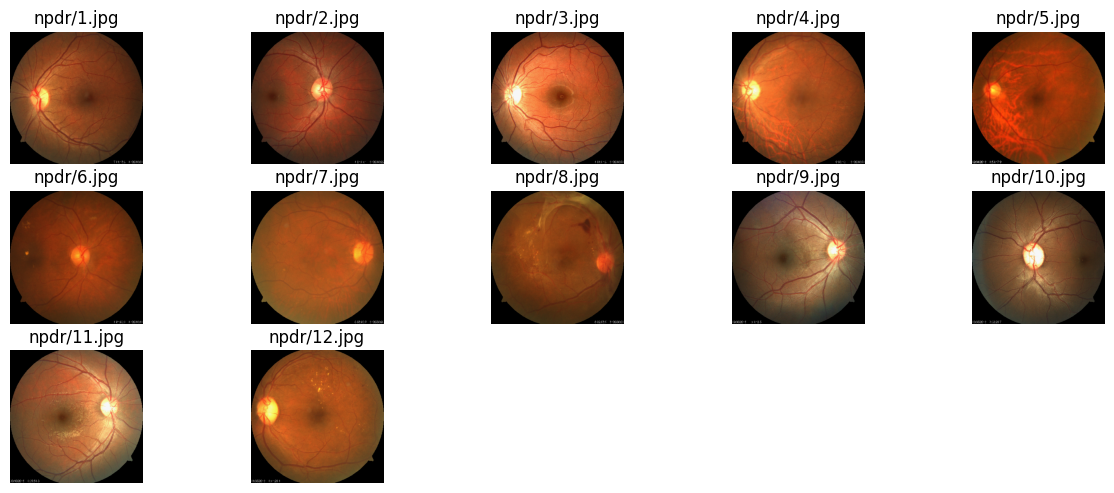

In [6]:
# Plot images

a = train_generator.class_indices
class_names = list(a.keys()) # storing class names in a list


# def plot_images(img, labels):
# 	plt.figure(figsize=[15, 10])
# 	for i in range(25):
# 		plt.subplot(5, 5, i+1)
# 		plt.imshow(img[i])
# 		plt.title(class_names[np.argmax(labels[i])])
# 		plt.axis('off')

# plot_images(x,y)


def plot_images_with_numbers(img, labels, image_numbers):
    plt.figure(figsize=[15, 10])
    for i in range(batch_size):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(f"{image_numbers[i]}")
        plt.axis('off')

plot_images_with_numbers(x, y, labels[x_name][:batch_size])  # Plot the first 25 images and their numbers


In [7]:
# Define a function to create and compile models with different architectures
def create_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        BatchNormalization(renorm=True), #normalize the activations
        GlobalAveragePooling2D(), # reduce spatial dimensions.
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.5), # prevent overfitting.
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
import tensorflow as tf

print('TensorFlow version:',tf.__version__)
physical_devices = tf.config.list_physical_devices()
for dev in physical_devices:
    print(dev)

sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print("CUDA version:",cuda_version)
cudnn_version = sys_details["cudnn_version"]
print("CUDNN version:",cudnn_version)

TensorFlow version: 2.13.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
CUDA version: 11.8
CUDNN version: 8


2023-09-15 16:19:40.332371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 16:19:40.403348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 16:19:40.403488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
# Check if TensorFlow is using the GPU
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True


2023-09-15 12:22:28.585402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 12:22:28.637672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 12:22:28.637818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [22]:

import theano
import lasagne
import theano.tensor as T

# Define the model architecture using Lasagne
def create_lasagne_model(input_shape, num_classes):
    # Input layer
    l_in = lasagne.layers.InputLayer(shape=input_shape)

    # Add layers as per your model architecture
    # Example:
    l_hidden1 = lasagne.layers.DenseLayer(l_in, num_units=128, nonlinearity=lasagne.nonlinearities.rectify)
    l_out = lasagne.layers.DenseLayer(l_hidden1, num_units=num_classes, nonlinearity=lasagne.nonlinearities.softmax)

    return l_out

# Define placeholders for input and target
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

# Create the model
model = create_lasagne_model((None, 3, 331, 331), num_classes=3)

# Define the loss and update rules
prediction = lasagne.layers.get_output(model)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()
params = lasagne.layers.get_all_params(model, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

# Compile functions for training and evaluation
train_fn = theano.function([input_var, target_var], loss, updates=updates)
val_fn = theano.function([input_var, target_var], [loss, prediction])

# Experiment with different base models
base_models = {
    "EfficientNetB3": create_lasagne_model((None, 3, 331, 331), num_classes=3),
    "ResNet50": create_lasagne_model((None, 3, 331, 331), num_classes=3),
    "VGG16": create_lasagne_model((None, 3, 331, 331), num_classes=3)
}

results = {}

for model_name, base_model in base_models.items():
    model = create_model(base_model, (331, 331, 3), num_classes=3)
    
    # Define early stopping callback to monitor the 'accuracy' metric and prevent overfitting.
    # Training is stopped early if the accuracy doesn't improve after a certain number of epochs (controlled by patience)
    early = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True, monitor='accuracy')
    
    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=25,
        callbacks=[early]
    )
    
    # Save or analyze the model and its performance
    # Store the results in the dictionary
    results[model_name] = {
        "model": model,
        "history": history.history
    }


AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)

In [8]:
# Experiment with different base models
base_models = {
    "EfficientNetB3": EfficientNetB3(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "ResNet50": ResNet50(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "VGG16": VGG16(input_shape=(331, 331, 3), include_top=False, weights='imagenet')
}

results = {}

for model_name, base_model in base_models.items():
    model = create_model(base_model, (331, 331, 3), num_classes=3)
    
    # Define early stopping callback to monitor the 'accuracy' metric and prevent overfitting.
    # Training is stopped early if the accuracy doesn't improve after a certain number of epochs (controlled by patience)
    early = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True, monitor='accuracy')
    
    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=25,
        callbacks=[early]
    )
    
    # Save or analyze the model and its performance
    # Store the results in the dictionary
    results[model_name] = {
        "model": model,
        "history": history.history
    }



2023-09-15 16:37:47.203366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 16:37:47.243228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 16:37:47.243373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/25


2023-09-15 16:38:02.093881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-15 16:38:03.459369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-15 16:38:04.049011: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faa56051f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-15 16:38:04.049028: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-09-15 16:38:04.052440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-15 16:38:04.144667: I ./tensorflow/compiler/jit/device_

11/11 [==============================] - 13s 357ms/step - loss: 1.1288 - accuracy: 0.3821
Epoch 2/25
11/11 [==============================] - 4s 363ms/step - loss: 1.0876 - accuracy: 0.4309
Epoch 3/25
11/11 [==============================] - 4s 365ms/step - loss: 1.0563 - accuracy: 0.5041
Epoch 4/25
11/11 [==============================] - 4s 374ms/step - loss: 1.1338 - accuracy: 0.4318
Epoch 5/25
11/11 [==============================] - 4s 366ms/step - loss: 1.0362 - accuracy: 0.4553
Epoch 6/25
11/11 [==============================] - 4s 342ms/step - loss: 1.0524 - accuracy: 0.4065
Epoch 7/25
11/11 [==============================] - 4s 381ms/step - loss: 1.0592 - accuracy: 0.4472
Epoch 8/25
11/11 [==============================] - 4s 358ms/step - loss: 1.0510 - accuracy: 0.4634
Epoch 9/25
11/11 [==============================] - 4s 388ms/step - loss: 1.0916 - accuracy: 0.4318
Epoch 10/25
11/11 [==============================] - 4s 342ms/step - loss: 1.0549 - accuracy: 0.3821
Epoch 11/

2023-09-15 16:40:51.063379: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-15 16:40:51.142194: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


11/11 [==============================] - 9s 384ms/step - loss: 1.1218 - accuracy: 0.4065
Epoch 2/25
11/11 [==============================] - 4s 384ms/step - loss: 1.0911 - accuracy: 0.4472
Epoch 3/25
11/11 [==============================] - 4s 374ms/step - loss: 1.0858 - accuracy: 0.4472
Epoch 4/25
11/11 [==============================] - 4s 390ms/step - loss: 1.0092 - accuracy: 0.4715
Epoch 5/25
11/11 [==============================] - 4s 341ms/step - loss: 0.9549 - accuracy: 0.5854
Epoch 6/25
11/11 [==============================] - 4s 366ms/step - loss: 0.8934 - accuracy: 0.5935
Epoch 7/25
11/11 [==============================] - 4s 359ms/step - loss: 0.8456 - accuracy: 0.5854
Epoch 8/25
11/11 [==============================] - 4s 376ms/step - loss: 0.8042 - accuracy: 0.6260
Epoch 9/25
11/11 [==============================] - 4s 372ms/step - loss: 0.7223 - accuracy: 0.6504
Epoch 10/25
11/11 [==============================] - 4s 358ms/step - loss: 0.7047 - accuracy: 0.6992
Epoch 11/2

In [9]:
for model_name, data in results.items():
    print("model_name", model_name)
    model_object, history_object = data
    print("model_object", data[model_object])
    for measurement_name, measurements in data[history_object].items():
        print("measurement_name", measurement_name, "max measurements", max(measurements))
    
    print("\n")

# FYI data structure is as
    # results[model_name] = {
    #     "model": model,
    #     "history": history.history
    # }

model_name EfficientNetB3
model_object <keras.src.engine.sequential.Sequential object at 0x7fad26a69590>
measurement_name loss max measurements 1.1338366270065308
measurement_name accuracy max measurements 0.5040650367736816


model_name ResNet50
model_object <keras.src.engine.sequential.Sequential object at 0x7facac588c50>
measurement_name loss max measurements 1.2993468046188354
measurement_name accuracy max measurements 0.560606062412262


model_name VGG16
model_object <keras.src.engine.sequential.Sequential object at 0x7facac165b90>
measurement_name loss max measurements 1.1218286752700806
measurement_name accuracy max measurements 0.9512194991111755




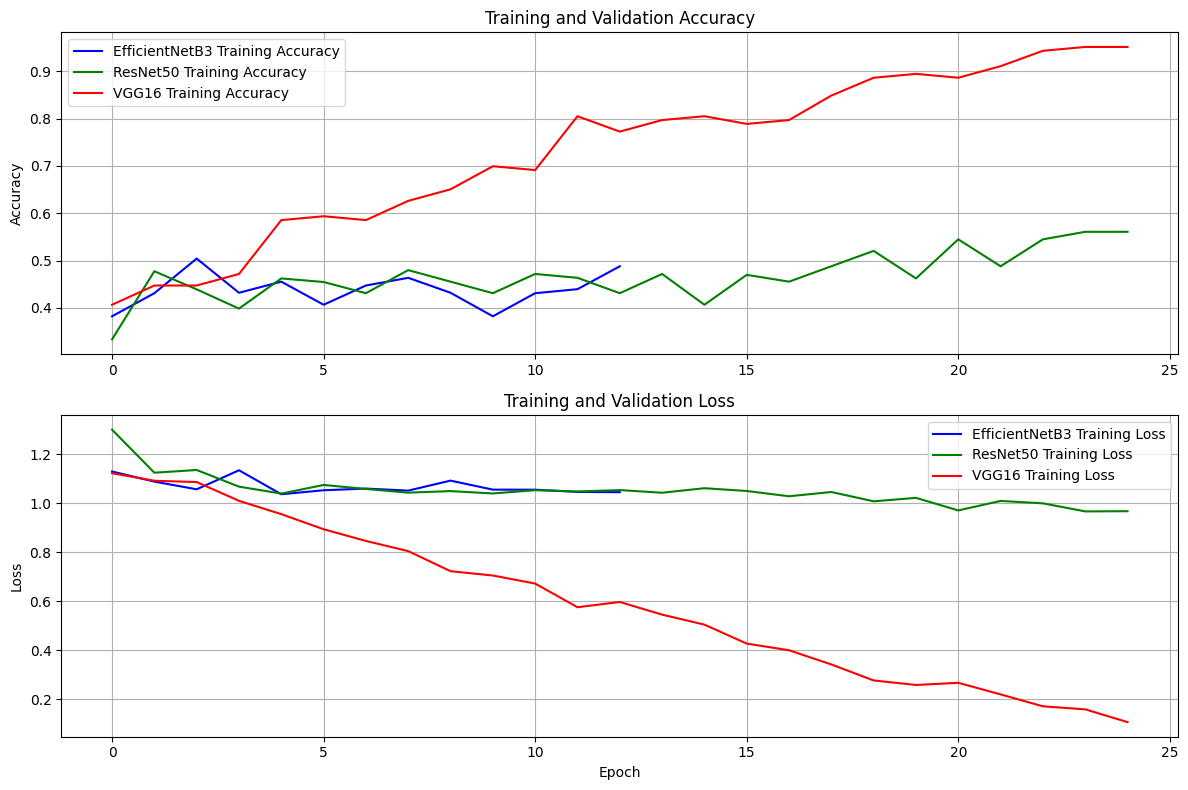

In [10]:
import matplotlib.pyplot as plt

# Create a list of colors for plotting
colors = ['b', 'g', 'r']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)

# Plot accuracy curves for each model
for idx, (model_name, data) in enumerate(results.items()):
    history = data["history"]
    acc = history["accuracy"]
    plt.plot(acc, label=f'{model_name} Training Accuracy', color=colors[idx])

plt.legend()
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)

# Plot loss curves for each model
for idx, (model_name, data) in enumerate(results.items()):
    history = data["history"]
    loss = history["loss"]
    plt.plot(loss, label=f'{model_name} Training Loss', color=colors[idx])

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# Evaluate model

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


1/1 [==============================] - 2s 2s/step - loss: 0.1731 - accuracy: 1.0000
[0.17310817539691925, 1.0]
Accuracy: 100.0000%
Loss:  0.17310817539691925


1/1 [==============================] - 0s 16ms/step
Prediction: [[2.3052589e-08 3.5756156e-07 9.9999964e-01]]
Labels: ['healthy', 'npdr', 'pdr']
Predicted class: pdr


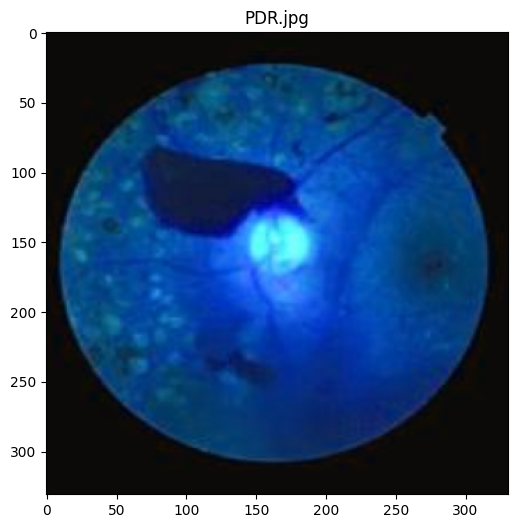

In [19]:
# Testing

test_img_path = os.path.join(test_path, "healthy/105.jpg")
test_img_path = os.path.join("PDR.jpg")
# test_img_path="PDR.jpg"
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255
 
plt.figure(figsize=(6,6))
plt.title(test_img_path)
plt.imshow(resized_img[0])


img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)

print("Prediction:", prediction)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

print("Labels:", possible_labels) # TODO check if this is matched properly
print("Predicted class:", possible_labels[predicted_class_index])



In [13]:
# Save model

model.save("models/1508.h5")
